# OECD - International comparisons - new API

## Python setup

In [1]:
from io import StringIO
from pathlib import Path
from typing import Sequence, cast

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [2]:
import common
import plotting as pg

In [3]:
# plotting stuff
plt.style.use("fivethirtyeight")
TARGET = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% inflation target",
    "zorder": -1,
}
TARGET_V = TARGET | {"xmin": 2, "xmax": 3}
del TARGET_V["ymax"]
del TARGET_V["ymin"]

# Where to put the charts
CHART_DIR = "./CHARTS/OECD/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
pg.set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

# display charts in notebook
SHOW = False

## OECD Preliminaries

In [4]:
# OECD updated data API
# https://sdmx.oecd.org/public/rest/data/
# <agency identifier>,<dataflow identifier>,<dataflow version>/
# <filter expression>[?<optional parameters>]

# See: https://data-explorer.oecd.org/?lc=en

SOURCE = "OECD: sdmx.oecd.org"
STEM = "https://sdmx.oecd.org/public/rest/data"

In [5]:
location_map = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CHL": "Chile",
    "CZE": "Czech Rep.",
    "DNK": "Denmark",
    "EST": "Estonia",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JPN": "Japan",
    "KOR": "Korea",
    "LVA": "Latvia",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovak Rep.",
    "SVN": "Slovenia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Turkey",
    "GBR": "United Kingdom",
    "USA": "United States",
    "ARG": "Argentina",
    "BRA": "Brazil",
    "CHN": "China",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "IND": "India",
    "IDN": "Indonesia",
    "LTU": "Lithuania",
    "RUS": "Russia",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
    "ROU": "Romania",
}

In [6]:
def get_chart_groups() -> dict[str, list[str]]:
    """Get chart groups, with no more than 6 lines
    per chart."""

    of_interest = ["AUS", "USA", "CAN", "DEU", "GBR", "JPN"]
    anglosphere = ["AUS", "USA", "CAN", "NZL", "GBR", "IRL"]
    major_europe = ["FRA", "DEU", "ITA", "GBR", "RUS", "ESP"]
    largest_economies = ["USA", "CHN", "JPN", "DEU", "GBR", "IND"]
    asia = ["KOR", "JPN", "CHN", "IND", "IDN"]
    north_europe = ["DNK", "SWE", "NOR", "ISL", "FIN", "GBR"]
    baltic_europe = ["LVA", "LTU", "EST"]
    central_europe = ["CZE", "HUN", "SVK", "SVN", "POL", "GRC"]
    west_europe = ["BEL", "ESP", "PRT", "NLD", "LUX", "FRA"]
    italo_germanic_europe = ["DEU", "AUT", "CHE", "ITA"]
    n_america = ["USA", "CAN", "MEX"]
    c_s_america = ["CHL", "BRA", "COL", "CRI"]
    other = ["AUS", "NZL", "SAU", "ZAF", "ISR"]
    high_inflation = [
        "TUR",
        "ARG",
    ]

    charts = {
        "of_interest": of_interest,
        "anglosphere": anglosphere,
        "major_europe": major_europe,
        "largest_economies": largest_economies,
        "asia": asia,
        "north_europe": north_europe,
        "baltic_europe": baltic_europe,
        "central_europe": central_europe,
        "west_europe": west_europe,
        "italo_germanic_europe": italo_germanic_europe,
        "n_america": n_america,
        "c_s_america": c_s_america,
        "high_inflation": high_inflation,
        "other": other,
    }

    return charts


chart_sets = get_chart_groups()

## Utility

In [7]:
# plot Australia Vs OECD
PW_COUNTER = 0


def plot_world(
    data: pd.DataFrame,
    exclusions: None | list[str] = None,
    **kwargs,
) -> None:
    """Plot Australia vs the OECD."""

    # Exclude problematic OECD states
    data = data.rename(columns=location_map)
    if exclusions is not None:
        for c in exclusions:
            if c in data.columns:
                data = data.drop(c, axis=1)

    # plot remaining OECD states without legend label using the _ trick
    mapper = {x: f"_{x}" for x in data.columns}
    data = data.rename(columns=mapper)
    ax = data.plot(color="blue", lw=0.25, alpha=0.5)
    back = {y: x for x, y in mapper.items()}
    data = data.rename(columns=back)

    # plot mean if THRESHOLD proportion of non-na data points met
    threshold = 0.75
    mean = data.mean(axis=1).where(
        data.notna().sum(axis=1) >= len(data.columns) * threshold,
        other=np.nan,
    )
    mean.plot(ax=ax, color="darkblue", lw=2, label="OECD mean")

    # plot
    data["Australia"].dropna().plot(ax=ax, color="darkorange", lw=3, label="Australia")
    global PW_COUNTER
    PW_COUNTER = PW_COUNTER + 1
    pg.finalise_plot(
        ax,
        xlabel=None,
        y0=True,
        rfooter=SOURCE,
        tag=str(PW_COUNTER),
        legend={"loc": "best", "fontsize": "xx-small"},
        **kwargs,
        show=True,
    )

## GDP

https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN1@DF_QNA_EXPENDITURE_NATIO_CURR,1.0/Q.Y....B1GQ.....L..?startPeriod=2022-Q4&dimensionAtObservation=AllDimensions

Chain linked volume measures, national currency, seasonally adjusted

In [8]:
# Chain linked volume measures, national currency, seasonally adjusted
AGENCY_ID = "OECD.SDD.NAD"
DATAFLOW = "DSD_NAMAIN1@DF_QNA_EXPENDITURE_NATIO_CURR,1.0"
FILTER = "Q.Y....B1GQ.....L.."
OPTIONS = "startPeriod=1999-Q4&dimensionAtObservation=AllDimensions&format=csv"

In [9]:
def get_real_gdp_qtly_growth():

    url = f"{STEM}/{AGENCY_ID},{DATAFLOW}/{FILTER}?{OPTIONS}"
    contents = common.request_get(url).decode("utf-8")
    df = pd.read_csv(StringIO(contents))
    pvt = df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")

    pvt.index = pd.PeriodIndex(pvt.index, freq="Q")
    pvt = pvt.dropna(how='all', axis=1)
    remove = ['EU27_2020', 'EA20']
    pvt = pvt.drop(remove, axis=1)

    return (pvt.pct_change(fill_method=None) * 100).dropna(how="all")


gdp = get_real_gdp_qtly_growth()
gdp.columns

Index(['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI',
       'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV',
       'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA',
       'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'ROU', 'RUS', 'SAU', 'SVK', 'SVN',
       'SWE', 'TUR', 'USA'],
      dtype='object', name='REF_AREA')

In [10]:
def check_missing(df: pd.DataFrame) -> None:
    """Check rGDP data downloaded from OECD."""

    final_row = df.iloc[-1]
    missing_count = final_row.isna().sum()
    if missing_count:
        print(f"Final period: {final_row.name}")
        print(f"Missing data count for final period: {missing_count}")
        print(f"Missing data belongs to: {df.columns[final_row.isna()].to_list()}")
        print(f"Nations with final data: {df.columns[final_row.notna()].to_list()}")


check_missing(gdp)

Final period: 2023Q4
Missing data count for final period: 2
Missing data belongs to: ['NZL', 'RUS']
Nations with final data: ['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA']


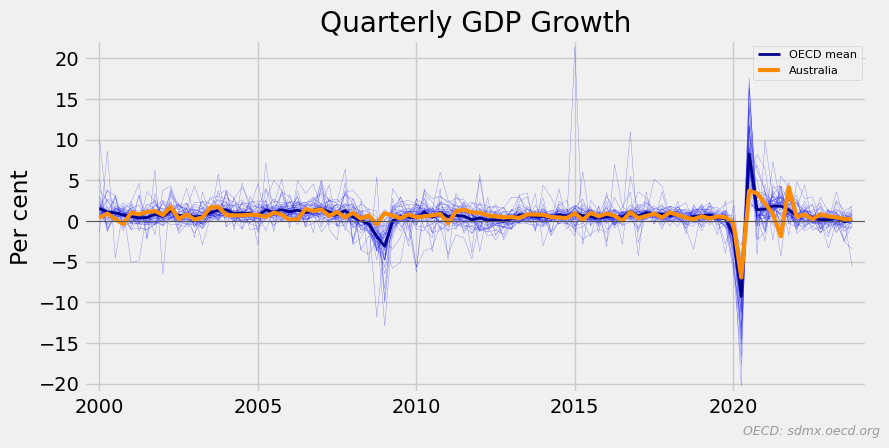

In [11]:
kwargs = {"title": "Quarterly GDP Growth", "ylabel": "Per cent"}
plot_world(gdp, **kwargs)

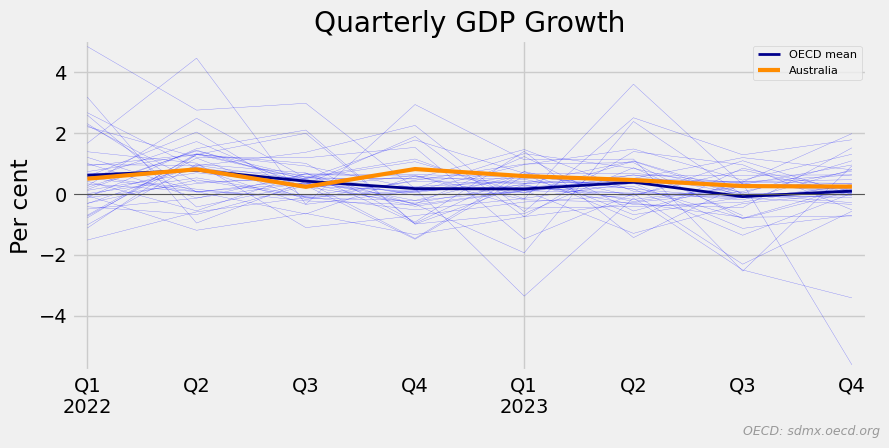

In [12]:
plot_world(gdp[gdp.index.year >= 2022], **kwargs)

In [13]:
def plot_contractions(growth: pd.DataFrame):
    """GDP identify/count quarterly contractions."""

    contractions = growth < 0
    contraction_count = contractions.sum(axis=1)

    start = pd.Period("2000Q1", freq="Q")
    title = "Num. OECD Monitored States with Qrtly GDP contraction"

    ax = contraction_count[contraction_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest nations in contraction, N={contraction_count.iloc[-1]}")
    print(
        ", ".join(
            [
                location_map[x]
                for x in contractions.iloc[-1][contractions.iloc[-1]].index
            ]
        )
    )


plot_contractions(gdp)

Latest nations in contraction, N=13
Brazil, Germany, Estonia, Finland, United Kingdom, Hungary, Ireland, Israel, Lithuania, Poland, Romania, Saudi Arabia, Sweden


In [14]:
def plot_recessions(growth: pd.DataFrame):
    """GDP identify/count technical recessions."""

    recessions = (growth < 0) & (growth.shift(1) < 0)
    recession_count = recessions.sum(axis=1)

    title = "Number of OECD Monitored States in Tech. Recession"
    start = pd.Period("2000Q1", freq="Q")
    ax = recession_count[recession_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    pg.finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=SOURCE,
        lfooter="Recession defined as two quarters of negative GDP growth",
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest N={recession_count.iloc[-1]}")
    print(
        ", ".join(
            [location_map[x] for x in recessions.iloc[-1][recessions.iloc[-1]].index]
        )
    )


plot_recessions(gdp)

Latest N=8
Germany, Estonia, Finland, United Kingdom, Ireland, Lithuania, Saudi Arabia, Sweden


## Inflation 

In [15]:
AGENCY_ID = "OECD.SDD.TPS"
DATAFLOW = (
    "DSD_PRICES@DF_PRICES_ALL,1.0",
    "DSD_PRICES_COICOP2018@DF_PRICES_C2018_ALL,1.0",
)
FILTER = (
    ".M.N.CPI.PA._T.N.GY",
    ".M.N.CPI.PA._T.N.GY",
)
OPTIONS = "startPeriod=2019-07&format=csv"

EXCLUDE = ["Turkey", "Russia", "Argentina"]
# Turkey and Argentina have rampant inflation
# Russia not updating data during war

In [16]:
def get_annual_inflation() -> pd.DataFrame:
    """Get OECD Annual Inflation Data."""

    combined = None
    for df, filter_ in zip(DATAFLOW, FILTER):
        url = f"{STEM}/{AGENCY_ID},{df}/{filter_}?{OPTIONS}"
        contents = common.request_get(url).decode("utf-8")
        df = pd.read_csv(StringIO(contents))
        pvt = df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")
        if combined is None:
            combined = pvt
        else:
            for c in pvt.columns:
                if c in combined.columns:
                    combined = combined.drop(c, axis=1)
            combined = pd.concat([combined, pvt], axis=1)
    return combined


annual_inflation = get_annual_inflation()
annual_inflation.index = pd.PeriodIndex(annual_inflation.index, freq="M")

In [17]:
def get_recent_ohlc(data: pd.DataFrame) -> pd.DataFrame:
    """For a dataset, build a table of Open, Highm Low, Close
    points for last valid 13 months in each column."""

    # compare progress over 13 months because Australia
    # and New Zealand only collect CPI measures quarterly
    inclusive_year = 13  # months
    index = ["Open", "High", "Low", "Close"]
    summary = pd.DataFrame([], index=index)  # return vehicle
    for name in data.columns:
        if name in EXCLUDE:
            continue
        column = data[name]
        last_valid = cast(pd.Period, column.last_valid_index())  # mypy cast
        year = pd.period_range(end=last_valid, periods=inclusive_year)
        frame = column[year]
        open_ = frame.iloc[0]
        high = frame.max()
        low = frame.min()
        close = frame.iloc[-1]
        key = f"{name} {str(last_valid.year)[2:]}-{last_valid.month:02d}"
        summary[key] = pd.Series([open_, high, low, close], index=index)
    summary = summary.T.sort_values("Close")
    return summary

In [18]:
def plot_ohlc(ohlc_df: pd.DataFrame, horizontal: bool = True, **kwargs) -> None:
    """Plot data in ohlc_df in a open-high-low-close style."""

    def xy(x, y):
        return (x, y) if horizontal else (y, x)

    def set_limits(ax: plt.Axes) -> None:
        minimum = min(0, ohlc_df["Low"].min())  # include zero
        maximum = ohlc_df["High"].max()
        adjustment = (maximum - minimum) * 0.025
        limits = minimum - adjustment, maximum + adjustment
        if horizontal:
            ax.set_xlim(*limits)
        else:
            ax.set_ylim(*limits)

    # canvass
    _, ax = plt.subplots()

    # sort out chart orientation
    good, bad = "darkblue", "darkorange"  # for colour blindness
    bar_method = ax.barh if horizontal else ax.bar
    reference = "left" if horizontal else "bottom"
    range_ = ohlc_df["High"] - ohlc_df["Low"]
    open_marker = "^" if horizontal else "<"
    close_marker = "v" if horizontal else ">"
    color = [
        good if open > close else bad
        for open, close in zip(ohlc_df.Open, ohlc_df.Close)
    ]

    # plot
    bar_method(
        ohlc_df.index,
        range_,
        **{reference: ohlc_df["Low"]},
        color=color,
        linewidth=1.0,
        edgecolor="black",
        label="Range of prints through the 13 months",
        alpha=0.15,
    )
    ax.plot(
        *xy(ohlc_df["Open"], ohlc_df.index),
        marker=open_marker,
        linestyle="None",
        label="First print in the 13 months",
        color=good,
        markersize=5,
    )
    ax.plot(
        *xy(ohlc_df["Close"], ohlc_df.index),
        marker=close_marker,
        linestyle="None",
        label="Last print in the 13 months",
        color=bad,
        markersize=5,
    )
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    set_limits(ax=ax)
    if not horizontal:
        ax.set_xticklabels(ohlc_df.index, rotation=90)
    pg.finalise_plot(ax, **kwargs)

In [19]:
def get_lim(df):
    """Get the limits of the data plus some wriggle room."""

    adjust = (df["High"].max() - df["Low"].min()) * 0.02
    return min(0, df["Low"].min()) - adjust, df["High"].max() + adjust

In [20]:
class InflationPlotter:
    """Plots recent inflation range for selected nations."""

    plot_count = 0

    def plot_selected(self, nations: Sequence, horizontal: bool) -> None:
        """Plot of Inflation over the [ast year - selected nations."""

        inflation = annual_inflation.rename(columns=location_map)
        summary = get_recent_ohlc(inflation[nations])

        title_aip = "Annual inflation prints over the most recent year"
        lfooter = (
            "Year and month of latest print in the axis labels. "
            "Range is the 13 months up to and including the latest data. "
        )
        plot_ohlc(
            summary,
            horizontal=horizontal,
            title=title_aip,
            xlim=get_lim(summary) if horizontal else None,
            zero_y=horizontal,
            xlabel="Per cent per year" if horizontal else None,
            ylabel="Per cent per year" if not horizontal else None,
            tag=str(InflationPlotter.plot_count),
            axvspan=TARGET_V if horizontal else None,
            axhspan=TARGET if not horizontal else None,
            y0=not horizontal,
            x0=horizontal,
            legend={"loc": "best", "fontsize": "xx-small"},
            rfooter=SOURCE,
            lfooter=lfooter,
            show=SHOW,
        )
        InflationPlotter.plot_count += 1


ip = InflationPlotter()
ip.plot_selected(
    nations=[
        "Australia",
        "Canada",
        "China",
        "France",
        "Germany",
        "India",
        "Indonesia",
        "Italy",
        "Japan",
        "Korea",
        "United Kingdom",
        "United States",
        # "New Zealand",   # NZ data appears to be missing from new API
        "Norway",
        "Sweden",
        "Brazil",
        "Spain",
    ],
    horizontal=True,
)

all_nations = [
    location_map[x]
    for x in annual_inflation.columns
    if x in location_map and x != "ARG"
]
ip.plot_selected(all_nations, horizontal=False)
del ip

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_56853/2525698637.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


In [21]:
def plot_annual_inflation(inflation: pd.DataFrame) -> None:
    """Quick Annual Inflation Charts"""

    for title, chart_set in chart_sets.items():
        chart_set = sorted(set(chart_set).intersection(set(inflation.columns)))
        cs = inflation[chart_set].rename(columns=location_map)
        pg.line_plot(
            cs,
            title="Annual Consumer Price Inflation",
            ylabel="Per cent per Year",
            tags=title,
            xlabel=None,
            axhspan=TARGET,
            dropna=True,
            y0=True,
            width=2,
            rfooter=SOURCE,
            show=SHOW,
        )


plot_annual_inflation(annual_inflation)

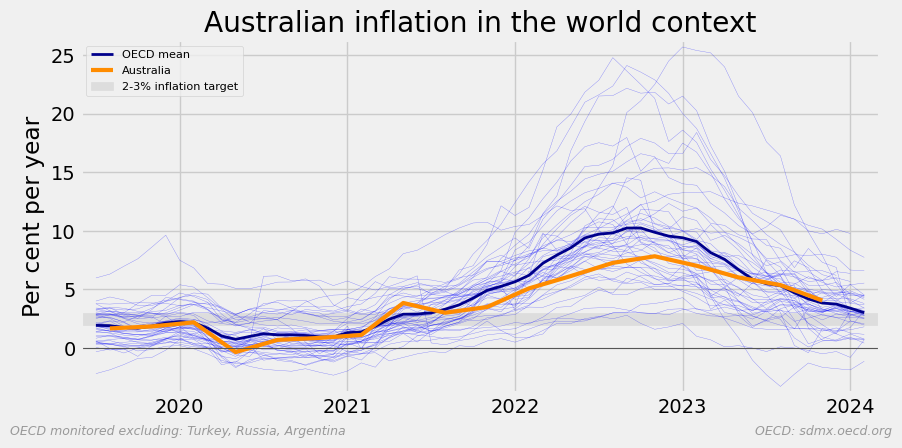

In [22]:
kwargs = {
    "title": "Australian inflation in the world context",
    "ylabel": "Per cent per year",
    "lfooter": f'OECD monitored excluding: {", ".join(EXCLUDE)}',
    "axhspan": TARGET,
}

plot_world(
    annual_inflation,
    exclusions = EXCLUDE,
    **kwargs,
)

## Finished

In [23]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Mar 21 2024 17:08:47

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

matplotlib: 3.8.3
numpy     : 1.26.4
pandas    : 2.2.1

Watermark: 2.4.3

